In [157]:
from math import e
from random import random
from time import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Introduction

No-one ever said that finding true love was easy. And though for the lucky few, Valentine's day can be a time filled with love and affection, for many people it can just be a harsh reminder of this fact (such a pessimist, I know). 

Perhaps, though, statistics can lend us a hand. It may seem that the world of love and romance lies far from the realms of probabilistic reasoning and yet, surprisingly, the field might have some useful ideas to contribute.

Specifically, statistics is capable (under a few assumptions—which we'll get to later) of offering a solution to the question: "How do I find *the one*?". What makes this question so difficult to answer is that we are having to handle uncertainty. Until we end a relationship and move on, it's impossible (at least whilst retaining morals) to see if there could be something better with someone else. In most cases, we don't stress about this and simply settle for someone that makes us happy; blocking out any thoughts that there could be someone better. In pursuit of 'the one' however, this just won't do. Thankfully, this inherent uncertainty is a challenge that statistics is well-equipped to tackle.

### Modeling the Problem

If we want to solve this problem using statistics, we'll have to make some assumptions. Now, obviously, the more assumptions we implement, the less practical our statistical model becomes for actual match-making. But frankly, if you're getting your dating advice from a mathematician, I think you're far beyond the point of caring about real-world practicalities.

Our main assumption is that it is possible to estimate how many people you would be able to date in your life if you were to never settle down. We will call this number $n$. In practice, it may be difficult or even impossible to come up with this number. By sacrificing some rigour, however, we can be happy in simply accepting a best guess. We also assume that these $n$ people have an objective ranking so that there is a clear 'best' person—*the one*.

We then suppose that we are offered the chance to date each one of these $n$ people one at a time. After we get to know them, we make a choice: settle or move on. If we move on then there is no forgiveness; we can never return to that same person again. If we get to the $n$th person then we have no choice but to spend the rest of lives with them, for better or worse.

Although these assumptions may not be indicative of real life—though a world where we never have to think about rejection doesn't sound too bad—they are necessary to frame the problem in statistical terms. With the model out of the way, we are simply left to answer the question: what strategy will maximise our chances of settling with the best person? How can we find *the one*?

## The Solution

It turns out that the optimal strategy is surprisingly simple. It goes as follows:

* Take your best guess at $n$, the number of people you could possibly date in your life if you were never to settle down
* Divide $n$ by $e$ (known as Euler's number and equal to roughly $2.718$) and round the result to the nearest whole number. Call this number $k$
* Date $k$ people, rejecting each one of them, keeping track of the best 
* Continue to date the other $n-k$ people, settling only if you find someone better than everyone you've seen so far (or you reach the $n$th person)

Admittedly, it's a bit of a cruel strategy; you have to feel some remorse for the $k$ people rejected without a fighting chance. As the saying goes though, you've got to break a few hearts to make an omelette (well, it went something like that at least).

Remarkably, it can be proved (and we will do so at the end of this post) that this is the unique optimal strategy that will maximise your chance of finding *the one*. Perhaps a better hypothetical talking point than an actually strategy for love but at least now you know.

### Speed Dating

But why should you trust that this is indeed the best strategy? Sure, I'll provide a statistical proof at the end of this post but I've no doubt that it won't be everyone's cup of tea.

Instead, I plan to prove this fact to you using some simulated speed dating. We look at values of $n$ ranging from 1 to 100, enough to verify my claim, and consider each possible cutoff $k$ from 0 (settling with the first person we meet) to $n-1$ (holding out for the last person). For each pair of $n$ and $k$ we will then simulate one million sets of $n$ people and try out the strategy for that specific $k$. We can then average over these one million simulations to see what proportion of the time we ended up with *the one*. In all, this equates to around $5.2$ billion dates. It takes my computer an hour or two to run all of these simulations, averaging around $700,000$ dates per second—a pace even the most decisive speed dater would struggle to match.

We then produce a heat map showing the likelihood of finding *the one* for each value of $k$ (rescaled so that the highest probability becomes one). This leaves us with a plot like this.

In [158]:
def simulate(max_n, best_only):
    vals = [random() for __ in range(max_n)]
    
    curr_max = vals[0]
    cummax, cutoffs = [curr_max], [0]
    for i, v in enumerate(vals[1:], 1):
        if v > curr_max:
            cutoffs.append(i)
            curr_max = v
        cummax.append(curr_max)
    cutoffs.append(max_n)
    
    best_choice = [[None for k in range(n+1)] for n in range(max_n)]
    curr_cutoff_idx, curr_cutoff = 0, 0
    for k in range(max_n):
        if k >= curr_cutoff:
            curr_cutoff_idx += 1
            curr_cutoff = cutoffs[curr_cutoff_idx]
        for n in range(k, max_n):
            choice = vals[curr_cutoff] if curr_cutoff <= n else vals[n]
            best_choice[n][k] = choice == cummax[n] if best_only else choice
    return best_choice

In [159]:
max_n = 101
num_iter =  10**6
tot_best = [[0 for k in range(n+1)] for n in range(max_n)]
for __ in range(num_iter):
    sim_best = simulate(max_n, True)
    for n in range(max_n):
        for k in range(n+1):
            tot_best[n][k] += sim_best[n][k]
prop_best = [[None for k in range(n+1)] for n in range(max_n)]
for n in range(max_n):
    for k in range(n+1):
        prop_best[n][k] = tot_best[n][k] / num_iter
props_best_mtrx = np.zeros((max_n, max_n))
for n in range(max_n):
    for k in range(n+1):
        props_best_mtrx[k][n] = props_best[n][k]
props_best_mtrx = props_best_mtrx / props_best_mtrx.max(axis=1)[:, np.newaxis]

In [160]:
best_k = np.argmax(props_best_mtrx, axis=0)

In [161]:
expected_k = np.arange(max_n) / e

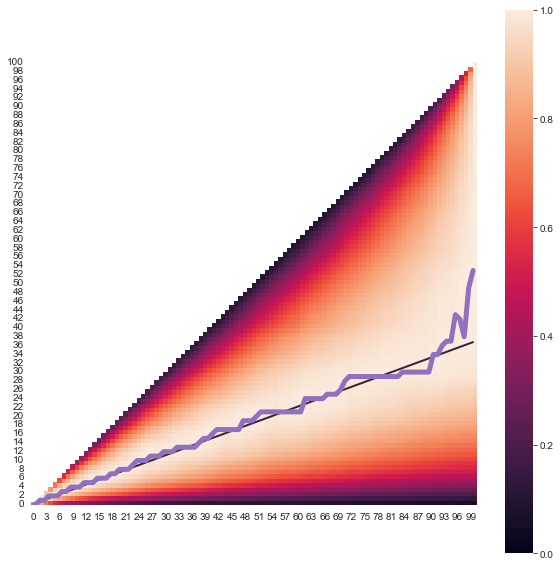

In [162]:
mask = np.zeros_like(props_best_mtrx)
mask[np.triu_indices_from(mask)] = True
mask = np.transpose(mask)
with sns.axes_style('white'):
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(props_best_mtrx, mask=mask, vmax=1., square=True)
    ax.invert_yaxis()
    plt.plot(np.arange(max_n), expected_k, color='#382234', linewidth=2)
    plt.plot(np.arange(max_n), best_k, color='#8f71bf', linewidth=5)
    plt.show()

I've also included two lines. The purple line line tracks which value of $k$ was the best of the $n$ available based on our simulations. The black meanwhile shows the line $k=\frac{n}{e}$—the trend we'd expect the purple line to follow if the procedure above was indeed optimal. The fit isn't perfect but that is expected with simulation; even with one million iterations there will still be a substantial amount of random noise to contend with. The important point is that the simulated line typically is very close to our predicted black line, offering strong evidence that the statement is indeed correct.

In general, the noise introduced by simulation is worse for large $n$. On the other hand, the true validity of the optimal method improves as $n$ increases. For small $n$ (say, single digit values) using a cutoff of $\frac{n}{e}$ will perform well but will not quite be optimal. If your value of $n$ falls into this category then you are better off using the table below instead.

It is also reasonable to ask the chances be of finding *the one* if we were to follow this strategy. It turns out that Euler's number, $e$, makes another appearance here as the probability of ending up with the best match approaches $\frac{1}{e}$ or about $0.368$ as $n$ grows. Not terrible odds if you ask me.

### A Compromise

Perhaps, though, you simply don't believe in *the one* and would rather just maximise the expected value of the person you settle down with instead of aiming for nothing less than the best. If this is the case then you're in luck; a small modification to the above method can solve this problem too.

In this scenario, we will assign each person a value between $0$ and $1$ which represents what proportion of all possible partners would be less preferable to settle with. For example, a person with a value of $0.6$ would be preferred over $60\%$ of other people. Our question now becomes, what strategy do we follow to maximise the expected value of the person we end up settling with.

It turns out that the optimal strategy for this scenario is exactly the same as before except now we set $k=\sqrt{n}-1$ (after rounding) rather than $\frac{n}{e}$. As before, we can confirm this using simulation.

In [140]:
max_n = 101
num_iter =  10**6
sims_util = [simulate(max_n, False) for __ in range(num_iter)]
props_util = [[sum(sims_util[i][n][k] for i in range(num_iter)) / num_iter 
               for k in range(n+1)] 
              for n in range(max_n)]
props_util_dict = {'n': [], 'k': [], 'p': []}
props_util_mtrx = np.zeros((max_n, max_n))
for n in range(max_n):
    for k in range(n+1):
        props_util_mtrx[k][n] = props_util[n][k]
props_util_mtrx = props_util_mtrx / props_util_mtrx.max(axis=1)[:, np.newaxis]

In [190]:
best_k = np.argmax(props_util_mtrx, axis=0)

In [191]:
expected_k = np.sqrt(np.arange(max_n)) - 1

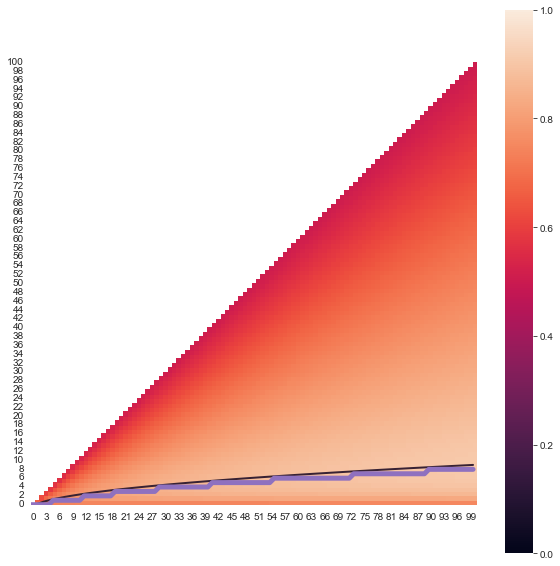

In [192]:
mask = np.zeros_like(props_util_mtrx)
mask[np.triu_indices_from(mask)] = True
mask = np.transpose(mask)
with sns.axes_style('white'):
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(props_util_mtrx, mask=mask, vmax=1., square=True)
    ax.invert_yaxis()
    plt.plot(np.arange(max_n), expected_k, color='#382234', linewidth=2)
    plt.plot(np.arange(max_n), best_k, color='#8f71bf', linewidth=5)
    plt.show()

## Prove Your Love

Before we bring things to a close, I wanted to offer a proof of the optimality of the procedure for maximising the chances of finding *the one*. A proof of the expected value optimising method can be found [here](https://www.academia.edu/1433655/Skip_the_Square_Root_of_n_A_New_Secretary_Problem) though it is slightly more involved.

The proof for the former scenario is surprisingly short and elegant. First observe that the optimal strategy has to be one of the form "reject $k$ people then choose the next best" since we should never settle for someone who is not the best that we have seen so far, since this could never be the best option. Furthermore, as we have no knowledge of the distribution of the potential partners' values it also makes no sense to reject a new best person after the first $k$.

With this in mind we denote $P(k)$ to be the probability of settling with the best person after rejecting the first $k$. Then we have:

$$
\begin{align}
P(k) &= \sum_{i=1}^n \mathbb{P}(\textrm{person } i \textrm{ is selected and is the best})\\
 &\stackrel{\text{Bayes}}{=} \sum_{i=1}^n \mathbb{P}(\textrm{person } i \textrm{ is selected}|\textrm{person } i \textrm{ is the best})\cdot\mathbb{P}(\textrm{person } i \textrm{ is the best})\\
 &= \frac{1}{n}\sum_{i=1}^n \mathbb{P}(\textrm{person } i \textrm{ is selected}|\textrm{person } i \textrm{ is the best})\\
 &= \frac{1}{n}\sum_{i=k+1}^n \mathbb{P}(\textrm{person } i \textrm{ is selected}|\textrm{person } i \textrm{ is the best})\\
  &= \frac{1}{n}\sum_{i=k+1}^n \frac{k}{i-1} \quad [\textrm{best of first } i-1 \textrm{ people is in first } k]\\
    &= \frac{k}{n}\sum_{i=k+1}^n \frac{1}{i-1}\\
\end{align}
$$

We now rearrange this so it becomes a Riemann sum.

$$
P(k) = \frac{k}{n}\sum_{i = k+1}^{n}\frac{n}{i-1}\frac{1}{n}
$$

We then let $n$ tend to infinity to obtain the following.

$$
P(k) = \lim_{n\rightarrow\infty}\frac{k}{n}\sum_{i = k+1}^{n}\frac{n}{i-1}\frac{1}{n} = x \int_x^1 \frac{dt}{t} = -x\ln x
$$

Here $x=\lim_{n\rightarrow\infty}\frac{k}{n}$ and $t=\lim_{n\rightarrow\infty}\frac{i-1}{n}$. It is not hard to verify that $x=\frac{1}{e}$ is the maximum of this function and so we optimise our odds of finding *the one* by setting $k=\frac{n}{e}$.

For small $n$ this method will not hold and we are instead forced to use dynamic programming (which is how I obtained the table for $n<10$ above).